# Import packages

In [351]:
# Load packages
%load_ext autoreload
%autoreload 2
from sklearn.cluster import SpectralClustering as sc
import numpy.random as rand
from numpy.linalg import norm as dist
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from functools import partial
from scipy.special import expit
from sklearn.linear_model import Ridge as ridge
from sklearn.linear_model import Lasso as lasso
from sklearn.linear_model import LinearRegression as ols
from sklearn.svm import SVR as kernel_svr
from sklearn.svm import LinearSVR as lin_svr
from sklearn.kernel_ridge import KernelRidge as kernel_ridge

from sklearn.tree import DecisionTreeRegressor as reg_tree
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import AdaBoostRegressor as ada_reg
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from sklearn.model_selection import GridSearchCV

import copy

import statsmodels.api as sm
import statsmodels.formula.api as smf

rmse = lambda x,y: np.power(mse(x,y), 0.5)

import pandas as pd

import multiprocessing
_n_cpu = multiprocessing.cpu_count()
print(_n_cpu)
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri as np2ri

robjects.numpy2ri.activate()

from rpy2.robjects.packages import importr
grf = importr('grf')
cf = grf.causal_forest

import GPy
from sklearn.metrics import mean_squared_error

# Apparently you may use different seed values at each stage
seed_value= 1234
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
8


# Import and preprocess data

In [542]:
# Load data

import pandas as pd

#####################################################
##### Define the appropriate path for your data #####
#####################################################
star_data = pd.read_csv('/STAR_Students_for_Uri.csv')



import numpy as np
#star_data = star_data.sample(n=200)
treatment_filter = np.isfinite(star_data.g1classtype)
outcome_filter = np.isfinite(star_data.g1tlistss + star_data.g1treadss + star_data.g1tmathss)

def _to_categorical(X):
    assert(type(X) == type(np.ones((1,))))
    return pd.get_dummies(pd.DataFrame(X.astype(str)), dummy_na=True).values.astype(np.int)

cat_covar_columns = ['race', 'birthmonth', 'birthyear', 'g1tchid', 'g1freelunch' ] 
_confounding_covar = 'g1surban'

# 'gkclasssize' same as gk and maybe g1
num_covar_columns = [ 'gktreadss', 'gktmathss', 'gktlistss']
Y_columns = [ 'g1treadss', 'g1tmathss', 'g1tlistss']


# all is post-filtering
# CHECKED
T_all = star_data.g1classtype[np.logical_and(treatment_filter, outcome_filter)].values # check

# Preprocessing this way we know the first column defines the Sex

X_all = np.c_[star_data.gender[np.logical_and(treatment_filter, outcome_filter)].values[T_all!=3]-1, _to_categorical(star_data[cat_covar_columns][np.logical_and(treatment_filter, outcome_filter)].fillna(0).values[T_all!=3])] #check
Y_cols = star_data[Y_columns][np.logical_and(treatment_filter, outcome_filter)].values[T_all!=3] # check 
urban = star_data.g1surban[np.logical_and(outcome_filter, treatment_filter)].values[T_all!=3] # check 

rural_filter = np.logical_or(urban==1, urban==3) # 1 = inner city, 3 = rural
urban_filter = np.logical_or(urban==2, urban==4) # 2 = suburban, 4 = urban

## FLIPPING AROUND TEMPORARILY
urban_filter = np.logical_or(urban==1, urban==3) # 1 = inner city, 3 = rural
rural_filter = np.logical_or(urban==2, urban==4) # 2 = suburban, 4 = urban
rural_teach_set = set(star_data[cat_covar_columns][np.logical_and(treatment_filter, outcome_filter)][T_all!=3].g1tchid[rural_filter])
urban_teach_set = set(star_data[cat_covar_columns][np.logical_and(treatment_filter, outcome_filter)][T_all!=3].g1tchid[~rural_filter])

T_all = star_data.g1classtype[np.logical_and(treatment_filter, outcome_filter)].values[T_all!=3] # removing 2s from T. check
T_all[T_all == 2] = 0 # check. 3 is control.
Y_all = np.sum(Y_cols, axis=1)/3


# ALL SHAPES ARE AS SHOULD BE!

# checked
X_rural = X_all[rural_filter]
X_urban = X_all[urban_filter]

# checked
T_rural = T_all[rural_filter]
T_urban = T_all[urban_filter]

#checked
Y_rural = Y_all[rural_filter]
Y_urban = Y_all[urban_filter] # + 20*(2*T_all[urban_filter]-1) # checked


#checked
X_rural_control = X_rural[T_rural==0]
X_rural_treated = X_rural[T_rural==1]

#checked
X_urban_control = X_urban[T_urban==0]
X_urban_treated = X_urban[T_urban==1]

#checked
Y_rural_control = Y_rural[T_rural==0]
Y_rural_treated = Y_rural[T_rural==1]

#checked
Y_urban_control = Y_urban[T_urban==0]
Y_urban_treated = Y_urban[T_urban==1]



# Define functions

In [543]:
def _generate_rct_obs(X_rural, Y_rural, T_rural, X_urban, Y_urban, T_urban, rct_fraction_of_rural = 0.5, eval_fraction_of_notrct = 0.4):
    #splitting rural into rct and not rct
    # checked
    """
    X_rural -> X_rct + X_rural_not_RCT
    
    X_rural_not_RCT + X_urban -> X_notrct
    
    X_notrct -> X_eval + X_noteval
    
    X_noteval -> X_noteval_urban + X_noteval_rural
    
    X_noteval_urban is further curropted
    
    
    """
    X_rct, X_rural_not_RCT, Y_rct, Y_rural_not_RCT, T_rct, T_rural_not_rct = train_test_split(X_rural,
                                                                                              Y_rural,
                                                                                              T_rural,
                                                                                              test_size = rct_fraction_of_rural) 
    #checked
    X_notrct = np.vstack((X_rural_not_RCT, X_urban))
    Y_notrct = np.hstack((Y_rural_not_RCT, Y_urban))
    T_notrct = np.hstack((T_rural_not_rct, T_urban))
    _local_rural_filter = np.array([True]*X_rural_not_RCT.shape[0] + [False]*X_urban.shape[0]).ravel()
    assert(_local_rural_filter.shape == Y_notrct.shape)
    
    X_eval, X_noteval, Y_eval, Y_noteval, T_eval, T_noteval, _local_rural_filter_eval, _local_rural_filter_noteval = train_test_split(X_notrct, Y_notrct, T_notrct, _local_rural_filter, test_size = 1 - eval_fraction_of_notrct) 
    
    X_noteval_rural = X_noteval[_local_rural_filter_noteval]
    Y_noteval_rural = Y_noteval[_local_rural_filter_noteval]
    T_noteval_rural = T_noteval[_local_rural_filter_noteval]
    
    # checked
    X_noteval_rural_treated = X_noteval_rural[T_noteval_rural==1]
    X_noteval_rural_control = X_noteval_rural[T_noteval_rural==0]
        
    #checked 
    Y_noteval_rural_treated = Y_noteval_rural[T_noteval_rural==1]
    Y_noteval_rural_control = Y_noteval_rural[T_noteval_rural==0]
    
    # OUTCOME BASED REMOVAL
    _treated_rural_filter = Y_noteval_rural_treated<np.median(Y_noteval_rural_treated)
    _treated_urban_filter = Y_urban_treated<np.median(Y_urban[T_urban==1])

    _treated_rural_filter = Y_noteval_rural_treated<np.percentile(Y_noteval_rural_treated, q=30)
    _treated_urban_filter = Y_urban_treated<np.percentile(Y_urban[T_urban==1], q=30)

    # remove large samples.
    X_obs_treated_rural = X_noteval_rural_treated[_treated_rural_filter,:]
    Y_obs_treated_rural = Y_noteval_rural_treated[_treated_rural_filter]
    
    X_obs_treated_urban = X_urban_treated[_treated_urban_filter,:]
    Y_obs_treated_urban = Y_urban_treated[_treated_urban_filter]
    
    
    assert(X_obs_treated_rural.shape[0] == Y_obs_treated_rural.shape[0])

    #checked
    X_obs = np.vstack((X_obs_treated_rural,
                       X_obs_treated_urban,
                       X_noteval_rural_control,
                       X_urban_control))

    #checked
    Y_obs = np.vstack((Y_obs_treated_rural.reshape(-1,1),
                       Y_obs_treated_urban.reshape(-1,1),
                       Y_noteval_rural_control.reshape(-1,1),
                       Y_urban_control.reshape(-1,1))).ravel()

    #checked
    T_obs = np.array([1]*int(Y_obs_treated_rural.shape[0] + Y_obs_treated_urban.shape[0]) + 
                     [0]*int(Y_noteval_rural_control.shape[0] + Y_urban_control.shape[0]))
    
    assert(Y_eval.shape == T_eval.shape)
    assert(Y_rct.shape == T_rct.shape)
    assert(Y_obs.shape == Y_obs.shape)
    assert(X_rct.shape[0] == T_rct.shape[0])
    assert(X_obs.shape[0] == T_obs.shape[0])
    assert(X_eval.shape[0] == T_eval.shape[0])
    
    return X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs, X_eval, Y_eval, T_eval

# Split data into RCT and Observational

In [544]:
# Apparently you may use different seed values at each stage
seed_value= 1234
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

rct_fraction_of_rural = 0.7
eval_fraction_of_notrct = 0.1

X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs, X_eval, Y_eval, T_eval = _generate_rct_obs(X_rural,
                                                                                     Y_rural,
                                                                                     T_rural,
                                                                                     X_urban,
                                                                                     Y_urban,
                                                                                     T_urban,
                                                                                     rct_fraction_of_rural = rct_fraction_of_rural,
                                                                                     eval_fraction_of_notrct = eval_fraction_of_notrct)

In [545]:
print("RCT sample size: ", X_rct.shape[0])
print("Observational sample size: ", X_obs.shape[0])
print("Evaluation set sample size: ", X_eval.shape[0])

RCT sample size:  422
Observational sample size:  2593
Evaluation set sample size:  379


# Define more functions that will be needed for training the models 

In [546]:
# Define functions that will be needed for modelling


def get_best_model_from_gridcv(X, Y, reg_parameter_pairs, print_flag = False, verbose = 0):
    val_errs = []
    models = []
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
    for reg, parameters in reg_parameter_pairs:
        if print_flag:
            print('trying ', str(reg)[:50])
        model = GridSearchCV(reg, parameters, cv=2, refit=True, verbose=verbose, n_jobs = 10)
        model.fit(X,Y)
        val_errs.append(rmse(y_test, model.predict(x_test)))
#         if print_flag:
#             print('trying ' + str(reg)[:60], val_errs[-1])
        models.append(copy.deepcopy(model.best_estimator_))
    min_ind = val_errs.index(min(val_errs))
    if verbose != 0:
        print(str(models[min_ind]), 'val rmse:{}'.format(val_errs[min_ind]))
    return copy.deepcopy(models[min_ind])


_mean_outcome = np.mean(Y_all)
_propensity = np.sum(T_all)/T_all.shape[0]
def ite_adjusted_outcome(Y,T,_propensity, c = _mean_outcome):
    assert(_propensity>0)
    assert(_propensity<1)
    assert(len(Y.shape) == 1)
    assert(Y.shape == T.shape )
    _ite = np.zeros(Y.shape)
    _ite[T==1] =  (Y[T==1]- c)/_propensity
    _ite[T==0] = -(Y[T==0] - c)/(1-_propensity)
    return _ite



rfr_reg_parameter_pairs = [(rfr(),{#'max_depth':[None] + list(range(2,11,4)),
                             'min_samples_leaf':list(range(1,11,3)), 
                             'n_estimators':[100, 200]})]

linear_reg_parameter_pairs = []
linear_reg_parameter_pairs.append((ridge(), {'alpha':np.logspace(-7, 7,8),
                                             'tol':[1e-3]}))


def run_method(X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs, _internal_X_not_rct):
    assert(X_rct.shape[0] == Y_rct.shape[0])
    assert(T_rct.shape[0] == Y_rct.shape[0])
    assert(X_obs.shape[0] == Y_obs.shape[0])
    assert(T_obs.shape[0] == Y_obs.shape[0])
    
    f1_rfr_model = get_best_model_from_gridcv(X_obs[T_obs==1], Y_obs[T_obs==1], rfr_reg_parameter_pairs)
    f0_rfr_model = get_best_model_from_gridcv(X_obs[T_obs==0], Y_obs[T_obs==0], rfr_reg_parameter_pairs)
    
    omega_rct_pred = f1_rfr_model.predict(X_rct).ravel() - f0_rfr_model.predict(X_rct).ravel()
    omega_obs_pred = f1_rfr_model.predict(X_obs).ravel() - f0_rfr_model.predict(X_obs).ravel()
    omega_all_pred = f1_rfr_model.predict(X_all).ravel() - f0_rfr_model.predict(X_all).ravel()
    omega_not_rct_pred = f1_rfr_model.predict(_internal_X_not_rct).ravel() - f0_rfr_model.predict(_internal_X_not_rct).ravel()
    
    #_mean_outcome_rct = np.mean(Y_rct)
    _propensity_rct = np.sum(T_rct)/T_rct.shape[0]
    cate_rct_est = ite_adjusted_outcome(Y_rct, T_rct, _propensity=_propensity_rct) # CHECKED

    # omega  and cate_rct_est should both have a shape (n_rct,)
    assert(cate_rct_est.shape == omega_rct_pred.shape)
    eta_rct_est = cate_rct_est - omega_rct_pred
    assert(len(eta_rct_est.shape) == 1)
    
    best_eta_est_linear = get_best_model_from_gridcv(X_rct, eta_rct_est, linear_reg_parameter_pairs)
    
    return copy.deepcopy(best_eta_est_linear), omega_obs_pred, omega_all_pred, omega_not_rct_pred


# Make Kallus approach with GPs
def run_methodGP(X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs, _internal_X_not_rct):
    assert(X_rct.shape[0] == Y_rct.shape[0])
    assert(T_rct.shape[0] == Y_rct.shape[0])
    assert(X_obs.shape[0] == Y_obs.shape[0])
    assert(T_obs.shape[0] == Y_obs.shape[0])
    
    # Naive GP trained on the observational data

    # Control
    kern = GPy.kern.RBF(input_dim=X_obs.shape[1], variance=1., lengthscale=1.)
    f0_gp_model = GPy.models.GPRegression(np.vstack(X_obs[T_obs==0]),
                                          np.vstack(Y_obs[T_obs==0]),
                                          kern)
    f0_gp_model.optimize()

    # Treated
    kern = GPy.kern.RBF(input_dim=X_obs.shape[1], variance=1., lengthscale=1.)
    f1_gp_model = GPy.models.GPRegression(np.vstack(X_obs[T_obs==1]),
                                          np.vstack(Y_obs[T_obs==1]),
                                          kern)
    f1_gp_model.optimize()

    # Predict the expectation
    omega_rct_pred = f1_gp_model.predict(np.vstack(X_rct))[0] - f0_gp_model.predict(np.vstack(X_rct))[0]
    omega_obs_pred = f1_gp_model.predict(np.vstack(X_obs))[0] - f0_gp_model.predict(np.vstack(X_obs))[0]
    omega_all_pred = f1_gp_model.predict(np.vstack(X_all))[0] - f0_gp_model.predict(np.vstack(X_all))[0]
    omega_not_rct_pred = f1_gp_model.predict(np.vstack(_internal_X_not_rct))[0] - f0_gp_model.predict(np.vstack(_internal_X_not_rct))[0]
    
    
    _propensity_rct = np.sum(T_rct)/T_rct.shape[0]
    #_mean_outcome_rct = np.mean(Y_rct)
    cate_rct_est = ite_adjusted_outcome(Y_rct, T_rct, _propensity=_propensity_rct) # CHECKED

    # omega  and cate_rct_est should both have a shape (n_rct,)
    #assert(cate_rct_est.shape == omega_rct_pred.shape)
    eta_rct_est = np.vstack(cate_rct_est) - np.vstack(omega_rct_pred)
    #assert(len(eta_rct_est.shape) == 1)
    
    best_eta_est_linear = get_best_model_from_gridcv(X_rct, eta_rct_est, linear_reg_parameter_pairs)
    
    return copy.deepcopy(best_eta_est_linear), omega_obs_pred, omega_all_pred, omega_not_rct_pred

In [547]:
X0_all = X_all[T_all==0]
X1_all = X_all[T_all==1]
Y0_all = Y_all[T_all==0]
Y1_all = Y_all[T_all==1]

In [548]:
# Define ground truth in the evaluation set

_mean_outcome = np.mean(Y_all)
_propensity = np.sum(T_all)/T_all.shape[0]
trueCATE = ite_adjusted_outcome(Y_eval, T_eval, _propensity = _propensity, c = _mean_outcome)

# Model Training

## Naïve GPs trained on the observational data

In [549]:
import GPy

# Data pre-processing
X0_obs = X_obs[T_obs==0]
X1_obs = X_obs[T_obs==1]
Y0_obs = Y_obs[T_obs==0]
Y1_obs = Y_obs[T_obs==1]

# Naive GP trained on the observational data

# Control
kern = GPy.kern.RBF(input_dim=X0_obs.shape[1], variance=1., lengthscale=1.)
m0_obs = GPy.models.GPRegression(np.vstack(X0_obs),np.vstack(Y0_obs),kern)
m0_obs.optimize()

# Treated
kern = GPy.kern.RBF(input_dim=X1_obs.shape[1], variance=1., lengthscale=1.)
m1_obs = GPy.models.GPRegression(np.vstack(X1_obs),np.vstack(Y1_obs),kern)
m1_obs.optimize()

# Predict the expectation
mu0_obs = m0_obs.predict(np.vstack(X_eval))[0]
mu1_obs = m1_obs.predict(np.vstack(X_eval))[0]
# Derive CATE
CATE_obs = mu1_obs - mu0_obs

## Naïve GPs trained on the RCT data

In [550]:
# Data pre-processing
X0_rct = X_rct[T_rct==0]
X1_rct = X_rct[T_rct==1]
Y0_rct = Y_rct[T_rct==0]
Y1_rct = Y_rct[T_rct==1]

# Naive GP trained on the observational data

# Control
kern = GPy.kern.RBF(input_dim=X0_rct.shape[1], variance=1., lengthscale=1.)
m0_rct = GPy.models.GPRegression(np.vstack(X0_rct),np.vstack(Y0_rct),kern)
m0_rct.optimize()

# Treated
kern = GPy.kern.RBF(input_dim=X1_rct.shape[1], variance=1., lengthscale=1.)
m1_rct = GPy.models.GPRegression(np.vstack(X1_rct),np.vstack(Y1_rct),kern)
m1_rct.optimize()

# Predict the expectation
mu0_rct = m0_rct.predict(np.vstack(X_eval))[0]
mu1_rct = m1_rct.predict(np.vstack(X_eval))[0]
# Derive CATE
CATE_rct = mu1_rct - mu0_rct

## Kallus Random Forest

In [551]:
eta_2step_model, omega_obs_pred_2step, omega_all_pred_2step, omega_eval_pred_2step = run_method(X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs, X_eval)

CATE_kallusRF = eta_2step_model.predict(X_eval).ravel() + omega_eval_pred_2step.ravel()


## Kallus GP

In [552]:
eta_2step_modelGP, omega_obs_pred_2stepGP, omega_all_pred_2stepGP, omega_eval_pred_2stepGP = run_methodGP(X_rct, Y_rct, T_rct, X_obs, Y_obs, T_obs, X_eval)
CATE_kallusGP = eta_2step_modelGP.predict(X_eval) + omega_eval_pred_2stepGP

## ICM

### First find the optimal value for $\rho$ 

In [364]:
# Data preprocessing
X_full = np.r_[X_rct, X_obs]
Y_full = np.r_[Y_rct, Y_obs]
T_full = np.r_[T_rct, T_obs]
S_full = np.r_[np.ones(X_rct.shape[0]), np.zeros(X_obs.shape[0])]
data_full = np.c_[S_full, X_full, T_full, Y_full]


In [365]:
from sklearn import linear_model
# Logistic regression model for the probability of participating in the trial
# S=1 is trial participation and S=0 is non participation 
logr = linear_model.LogisticRegression()
logr.fit(X_full,S_full)
prob = logr.predict_proba(X_full)
prob_part = prob[:,1]
prob_nonpart = prob[:,0]
data_full = np.c_[data_full, 1/prob_part]

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import numpy.random as nprand
import matplotlib.pyplot as plt
from functions.model_training import ICM
from functions.weightedMSE import weighted_mean_squared_error

seed_value = 1234

# Define range of rho values to search over
rho_values = np.round(np.arange(0, 1.05, 0.1), 1)

# Define number of folds for cross-validation
num_folds = 5  # Example: 5-fold cross-validation

# Initialize variables to store results
cv_rmse_values = []
rho_rmse_values = {}  # Dictionary to store RMSE values for each rho
min_avg_wmse = float('inf')
best_rho = None
wmse_per_rho = {}

# Perform 5-fold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed_value)
for rho in rho_values:
    seed_value= 1234
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)
    # 3. Set the `numpy` pseudo-random generator at a fixed value
    import numpy as np 
    np.random.seed(seed_value)
    print(f"Rho: {rho}")
    avg_wmse = 0
    fold_num = 0
    wmse_per_fold = []
    
    for train_index, val_index in kf.split(data_full):
        # 5 fold CV for experimental data: split them into 5 folds
        train_data, val_data= data_full[train_index], data_full[val_index]
        val_data = val_data[val_data[:,0]==1,:]
        
        X_train_rct = train_data[train_data[:,0]==1, 1:(train_data.shape[1]-4)]
        T_train_rct = train_data[train_data[:,0]==1, train_data.shape[1]-3]
        Y_train_rct = train_data[train_data[:,0]==1, train_data.shape[1]-2]
        X_train_obs = train_data[train_data[:,0]==0, 1:(train_data.shape[1]-4)]
        T_train_obs = train_data[train_data[:,0]==0, train_data.shape[1]-3]
        Y_train_obs = train_data[train_data[:,0]==0, train_data.shape[1]-2]

        X_val = val_data[val_data[:,0]==1, 1:(val_data.shape[1]-3)]

        m0, m1 = ICM(X_E=X_train_rct, X_O=X_train_obs, 
                     T_E=T_train_rct, T_O=T_train_obs, 
                     Y_E=Y_train_rct, Y_O=Y_train_obs,  
                     r=2, ID=X_train_rct.shape[1], 
                     AD=np.hstack(np.arange(0,X_train_rct.shape[1]).tolist()), 
                     rho=rho)

        predY0_exp = m0.predict_noiseless(np.c_[np.vstack(X_val), np.ones(X_val[:,1].shape[0]) * 0])
        predY1_exp = m1.predict_noiseless(np.c_[np.vstack(X_val), np.ones(X_val[:,1].shape[0]) * 0])
        predCATE_exp = predY1_exp[0] - predY0_exp[0]
        varCATE_exp = predY1_exp[1] + predY0_exp[1]

        wmse = weighted_mean_squared_error(weight=val_data[:,val_data.shape[1]-1], y_true=val_data[:, val_data.shape[1]-2], y_pred=predCATE_exp)
        avg_wmse += wmse
        wmse_per_fold.append(wmse)

        print(f"Fold {fold_num + 1} WMSE: {wmse}")
        fold_num += 1
    
    avg_wmse /= num_folds
    print(f"Average WMSE for Rho {rho}: {avg_wmse}")
    wmse_per_rho[rho] = wmse_per_fold

    # Update min_avg_wmse and best_rho if current avg_wmse is lower
    if avg_wmse < min_avg_wmse:
        min_avg_wmse = avg_wmse
        best_rho = rho

# Print the best rho and its corresponding min_avg_wmse
print(f"Best Rho: {best_rho}, Minimum Average WMSE: {min_avg_wmse}")


### Train ICM with the best $\rho$

In [554]:
m0, m1 = ICM(X_E=X_rct, X_O=X_obs, 
             T_E=T_rct, T_O=T_obs, 
             Y_E=Y_rct, Y_O=Y_obs,  
             r=2, ID=X_rct.shape[1], 
             AD=np.hstack(np.arange(0,X_rct.shape[1]).tolist()), 
             rho=best_rho)

In [555]:
predY0_exp_ICM = m0.predict_noiseless(np.c_[np.vstack(X_eval), np.ones(X_eval[:,1].shape[0]) * 0])
predY1_exp_ICM = m1.predict_noiseless(np.c_[np.vstack(X_eval), np.ones(X_eval[:,1].shape[0]) * 0])
CATE_ICM = predY1_exp_ICM[0] - predY0_exp_ICM[0]

# Compute Ground Truth

In [744]:
import pandas as pd
RMSE_RWD_rct_frac_rural_02_df = pd.DataFrame(np.c_[mean_squared_error(trueCATE, CATE_kallusGP, squared=False), 
                                                   mean_squared_error(trueCATE, CATE_kallusRF, squared=False), 
                                                   mean_squared_error(trueCATE, CATE_obs, squared=False), 
                                                   mean_squared_error(trueCATE, CATE_rct, squared=False),
                                                   mean_squared_error(trueCATE, CATE_ICM, squared=False)], 
                                                   columns=['Kallus GP', 'Kallus RF', 'GP obs', 'GP exp', 'ICM'])
RMSE_RWD_rct_frac_rural_02_df.to_csv('RMSE_RWD_rct_frac_rural_02.csv', index=False)

### PS model trained on all the data

In [756]:
# Compute propensity score on evalueation data
logr = linear_model.LogisticRegression()
logr.fit(X_all,T_all)
prob = logr.predict_proba(X_eval)
PS = prob[:,1]
prob_notreat = prob[:,0]

### Outcome model trained on all the data

In [709]:
import GPy

# Data pre-processing
X0_all = X_all[T_all==0]
X1_all = X_all[T_all==1]
Y0_all = Y_all[T_all==0]
Y1_all = Y_all[T_all==1]

# Naive GP trained on the observational data

# Control
kern = GPy.kern.RBF(input_dim=X0_all.shape[1], variance=1., lengthscale=1.)
m0_all = GPy.models.GPRegression(np.vstack(X0_all),np.vstack(Y0_all),kern)
m0_all.optimize()

# Treated
kern = GPy.kern.RBF(input_dim=X1_all.shape[1], variance=1., lengthscale=1.)
m1_all = GPy.models.GPRegression(np.vstack(X1_all),np.vstack(Y1_all),kern)
m1_all.optimize()

# Predict the expectation
mu0_all = m0_all.predict(np.vstack(X_eval))[0]
mu1_all = m1_all.predict(np.vstack(X_eval))[0]
# Derive CATE
CATE_all = mu1_all - mu0_all

In [757]:
def tauGT(Y,T):
    _tau = np.zeros(Y.shape[0])
    _tau[T==1] = (1-PS[T==1])*(Y[T==1] - np.hstack(mu1_all[T==1]))/((PS[T==1])*(1-PS[T==1])) + np.hstack(mu1_all[T==1]) - np.hstack(mu0_all[T==1])
    _tau[T==0] = (-PS[T==0])*(Y[T==0] - np.hstack(mu0_all[T==0]))/((PS[T==0])*(1-PS[T==0])) + np.hstack(mu1_all[T==0]) - np.hstack(mu0_all[T==0])
    return _tau

In [758]:
trueCATE = tauGT(Y_eval,T_eval)

# Compare models

In [759]:
print(mean_squared_error(trueCATE, CATE_kallusGP, squared=False))
print(mean_squared_error(trueCATE, CATE_kallusRF, squared=False))
print(mean_squared_error(trueCATE, CATE_obs, squared=False))
print(mean_squared_error(trueCATE, CATE_rct, squared=False))
print(mean_squared_error(trueCATE, CATE_ICM, squared=False))

41.62118702929054
39.07052467252291
57.89301578139973
43.1741055618713
37.86435169763139


# Save results

In [749]:
import pandas as pd
RMSE_RWD_rct_frac_rural_02_df = pd.DataFrame(np.c_[mean_squared_error(trueCATE, CATE_kallusGP, squared=False), 
                                                   mean_squared_error(trueCATE, CATE_kallusRF, squared=False), 
                                                   mean_squared_error(trueCATE, CATE_obs, squared=False), 
                                                   mean_squared_error(trueCATE, CATE_rct, squared=False),
                                                   mean_squared_error(trueCATE, CATE_ICM, squared=False)], 
                                                   columns=['Kallus GP', 'Kallus RF', 'GP obs', 'GP exp', 'ICM'])
RMSE_RWD_rct_frac_rural_02_df.to_csv('RMSE_RWD_rct_frac_rural_02.csv', index=False)

In [5]:
import pandas as pd
rmse = pd.read_csv('/RMSE_RWD_rct_frac_rural_02.csv')

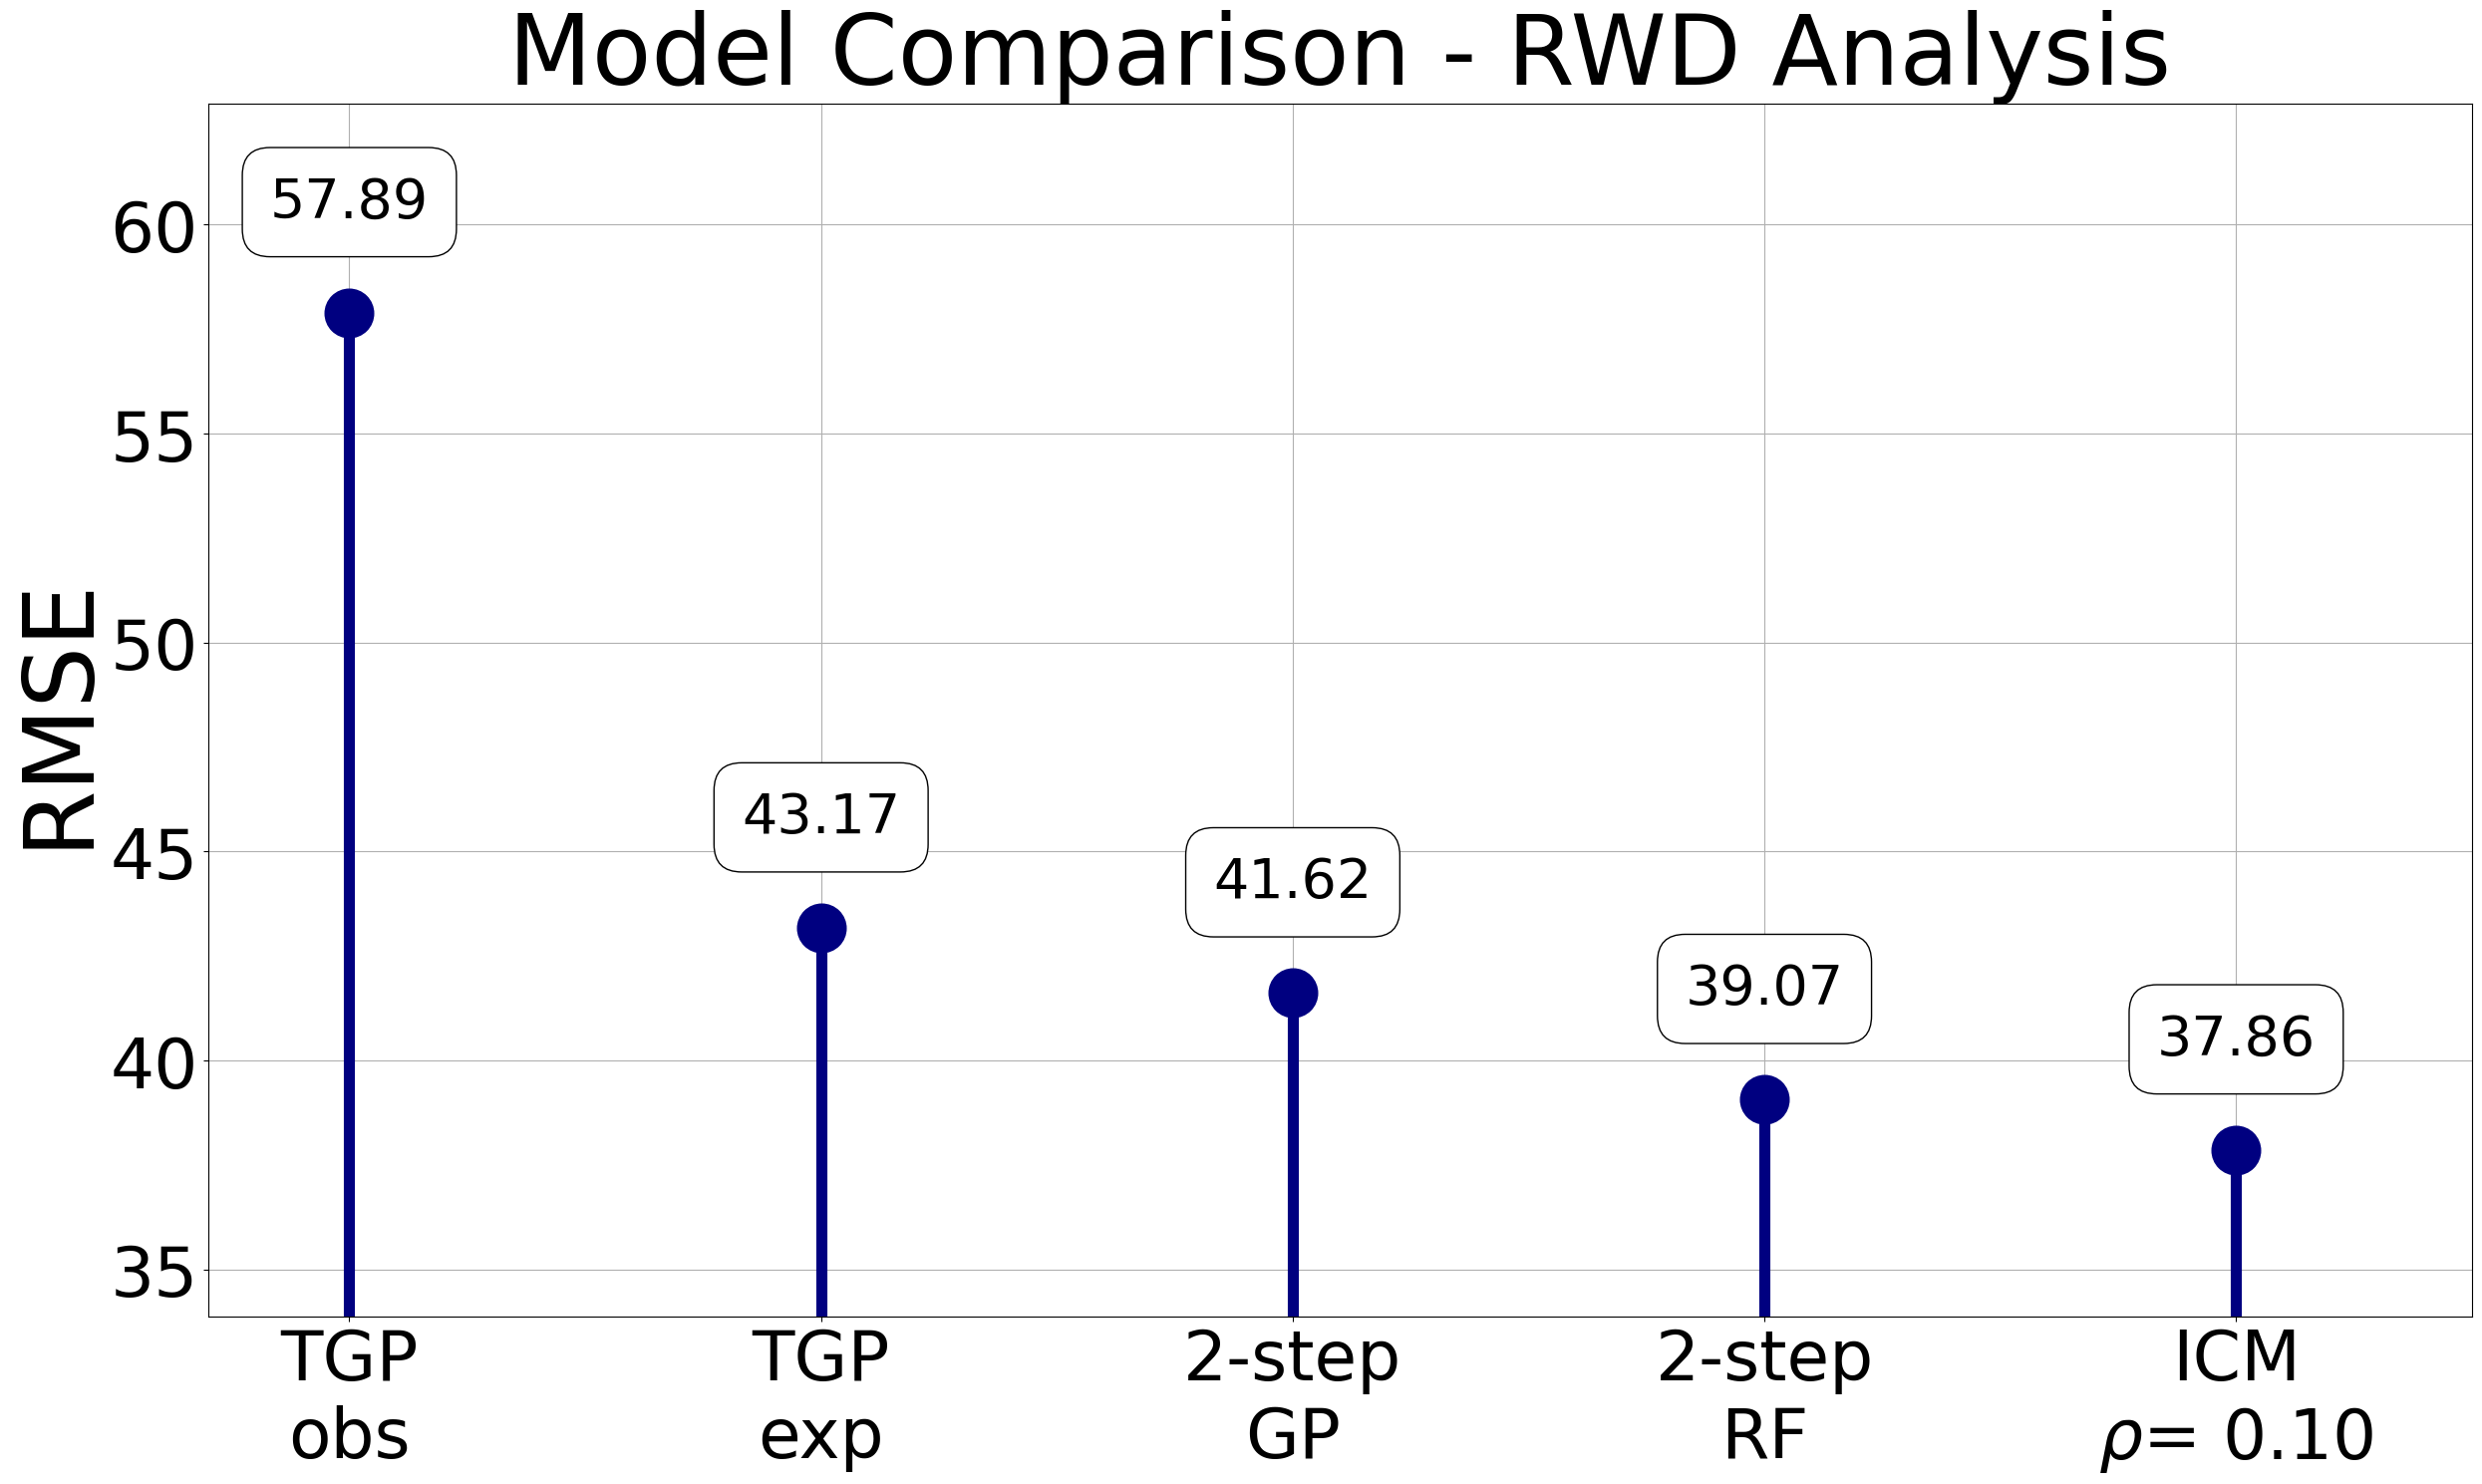

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

best_rho = 0.1

# RMSE values
rmse_values = [rmse['GP obs'].values[0],
               rmse['GP exp'].values[0],
               rmse['Kallus GP'].values[0],
               rmse['Kallus RF'].values[0],
               rmse['ICM'].values[0]]

# Method names
method_names = ['TGP\nobs', 'TGP\nexp', '2-step\nGP', '2-step\nRF', 'ICM\n$\\rho$= {:.2f}'.format(best_rho)]

# Plot
plt.figure(figsize=(25, 15))

# Plot vertical lines from x-axis to points
plt.vlines(method_names, 0, rmse_values, colors='navy', linestyles='solid', linewidth=8)

# Plot markers on top of the vertical lines
plt.plot(method_names, rmse_values, marker='.', markersize=70, linestyle=' ', color='navy')

# Annotate points with RMSE values
for i, txt in enumerate(rmse_values):
    plt.text(method_names[i], rmse_values[i] + 2, round(txt, 2), ha='center', va='bottom', fontsize=40, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.title('Model Comparison - RWD Analysis', fontsize=70)
plt.ylabel('RMSE', fontsize=70)
plt.xticks(ha='center', size=50)
plt.yticks(size=50)
plt.ylim(np.min(rmse_values) - 4, np.max(rmse_values) + 5)
plt.xlim(-0.3, 4.5)
plt.grid(True)
plt.tight_layout()
plt.show()
